In [4]:
import findspark
findspark.init()

In [40]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF, Tokenizer
from pyspark.ml.feature import NGram
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *

In [6]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime

In [7]:
spark = SparkSession.builder.appName('project03').getOrCreate()

In [8]:
df = spark.read.csv("df_clean.csv",inferSchema=True,header=True)

In [9]:
df.show(5)

+---+----------+--------------+----------------+------------------+------+--------------------+--------------------+--------------+--------------+--------+
|_c0|product_id|   customer_id|       full_name|      created_time|rating|             content|         new_content|count_positive|count_negative|  output|
+---+----------+--------------+----------------+------------------+------+--------------------+--------------------+--------------+--------------+--------+
|  1|  10119100|NguyenCatTuong|Nguyễn Cát Tường|20:22 | 21/12/2018|     4|Shop phục vụ khá ...|cửa tiệm phục_vụ ...|             2|             0|Positive|
|  2|  10119100|      VuPhuong|       Vũ Phương|15:00 | 10/12/2018|     3|Sản phẩm gần giốn...|         sản_phẩm   |             1|             0| Neutral|
|  5|  10119490|        lienla|         liên la|16:43 | 06/02/2021|     5|Giao hàng nhanh b...|giao hàng nhanh_c...|             2|             0|Positive|
|  6|  10119490|      DoanHanh|       Đoàn Hạnh|22:06 | 19/07/20

In [10]:
# Print the Schema of the DataFrame
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- created_time: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- content: string (nullable = true)
 |-- new_content: string (nullable = true)
 |-- count_positive: string (nullable = true)
 |-- count_negative: integer (nullable = true)
 |-- output: string (nullable = true)



In [11]:
# Repeat the process for the other categorical feature
df = StringIndexer(inputCol='count_positive',
                             outputCol='count_positive_idx',handleInvalid="skip").fit(df).transform(df)

In [12]:
df.show(5)

+---+----------+--------------+----------------+------------------+------+--------------------+--------------------+--------------+--------------+--------+------------------+
|_c0|product_id|   customer_id|       full_name|      created_time|rating|             content|         new_content|count_positive|count_negative|  output|count_positive_idx|
+---+----------+--------------+----------------+------------------+------+--------------------+--------------------+--------------+--------------+--------+------------------+
|  1|  10119100|NguyenCatTuong|Nguyễn Cát Tường|20:22 | 21/12/2018|     4|Shop phục vụ khá ...|cửa tiệm phục_vụ ...|             2|             0|Positive|               1.0|
|  2|  10119100|      VuPhuong|       Vũ Phương|15:00 | 10/12/2018|     3|Sản phẩm gần giốn...|         sản_phẩm   |             1|             0| Neutral|               0.0|
|  5|  10119490|        lienla|         liên la|16:43 | 06/02/2021|     5|Giao hàng nhanh b...|giao hàng nhanh_c...|         

In [13]:
df.select("output").distinct().show()

+--------+
|  output|
+--------+
|       0|
|Positive|
| Neutral|
|Negative|
+--------+



In [14]:
df = df.where(df.customer_id != 'NgoNguyenThiTruc')

In [15]:
df.select("output").distinct().show()

+--------+
|  output|
+--------+
|Positive|
| Neutral|
|Negative|
+--------+



In [16]:
# Feature Transformation
output_to_num = StringIndexer(inputCol='output', outputCol='label')

tokenizer = Tokenizer(inputCol='new_content', outputCol='token_content')
count_vec = CountVectorizer(inputCol='token_content', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')

In [17]:
clean_up = VectorAssembler(inputCols=['tf_idf','count_positive_idx','count_negative'],
                           outputCol='features')

In [18]:
# Pipeline
data_prep_pipe = Pipeline(stages=[output_to_num,
                                  tokenizer,
                                  count_vec,
                                  idf,
                                  clean_up])

In [19]:
cleaner = data_prep_pipe.fit(df)

In [20]:
clean_data = cleaner.transform(df)

In [21]:
clean_data.show(5)

+---+----------+--------------+----------------+------------------+------+--------------------+--------------------+--------------+--------------+--------+------------------+-----+--------------------+--------------------+--------------------+--------------------+
|_c0|product_id|   customer_id|       full_name|      created_time|rating|             content|         new_content|count_positive|count_negative|  output|count_positive_idx|label|       token_content|               c_vec|              tf_idf|            features|
+---+----------+--------------+----------------+------------------+------+--------------------+--------------------+--------------+--------------+--------+------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|  10119100|NguyenCatTuong|Nguyễn Cát Tường|20:22 | 21/12/2018|     4|Shop phục vụ khá ...|cửa tiệm phục_vụ ...|             2|             0|Positive|               1.0|  0.0|[cửa, tiệm, phục_...|(287

In [22]:
clean_data = clean_data.select(['label', 'features'])

In [23]:
clean_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(2878,[0,2,6,7,36...|
|  2.0|(2878,[1],[0.9761...|
|  0.0|(2878,[8,9,19,287...|
|  0.0|(2878,[1,3,2877],...|
|  0.0|(2878,[0,1,2,3,4,...|
+-----+--------------------+
only showing top 5 rows



In [24]:
clean_data.select("label").distinct().show()

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+



In [25]:
training, testing = clean_data.randomSplit([0.7,0.3])

In [26]:
# NaiveBayes
nb = NaiveBayes(featuresCol='features', labelCol='label', predictionCol='prediction')
start_time = datetime.now()
nb_model = nb.fit(training)
end_time = datetime.now()
nb_test_model = nb_model.transform(testing)
print('Running time:', end_time-start_time)

Running time: 0:00:02.258228


In [27]:
# DecisionTree
tree = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction')
start_time = datetime.now()
tree_model = tree.fit(training)
end_time = datetime.now()
tree_test_model = tree_model.transform(testing)
print('Running time:', end_time-start_time)

Running time: 0:00:10.025078


In [28]:
# RandomForest
rfc = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction')
start_time = datetime.now()
rfc_model = rfc.fit(training)
end_time = datetime.now()
rfc_test_model = rfc_model.transform(testing)
print('Running time:', end_time-start_time)

Running time: 0:00:08.296598


### Evaluate models

#### NaiveBayes

In [29]:
# Create a confusion matrix
nb_test_model.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   20|
|  1.0|       1.0|   51|
|  0.0|       1.0|   53|
|  1.0|       0.0|   24|
|  2.0|       2.0|   31|
|  2.0|       1.0|   10|
|  1.0|       2.0|   23|
|  0.0|       0.0| 1277|
|  0.0|       2.0|  119|
+-----+----------+-----+



In [30]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(nb_test_model)
print('Accuracy of model at predicting : {}'.format(acc))

Accuracy of model at predicting : 0.870225573905602


In [31]:
# Convert predictions to RDD
prediction_and_label = nb_test_model.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Calculate precision, recall, F1-score for each class
labels = nb_test_model.select("label").distinct().rdd.map(lambda r: r[0]).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support
    support = prediction_and_label.filter(lambda x: x[1] == label).count()

    print(f"Class {label}:")
    print(f"  Precision = {precision:.4f}")
    print(f"  Recall = {recall:.4f}")
    print(f"  F1-Score = {f1_score:.4f}")
    print(f"  Support = {support:.0f}")
    print()

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0:
  Precision = 0.9667
  Recall = 0.8813
  F1-Score = 0.9220
  Support = 1449

Class 1.0:
  Precision = 0.4474
  Recall = 0.5204
  F1-Score = 0.4811
  Support = 98

Class 2.0:
  Precision = 0.1792
  Recall = 0.5082
  F1-Score = 0.2650
  Support = 61



#### Decision Tree

In [32]:
# Create a confusion matrix
tree_test_model.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   43|
|  1.0|       1.0|   12|
|  0.0|       1.0|    5|
|  1.0|       0.0|   86|
|  2.0|       2.0|   17|
|  2.0|       1.0|    1|
|  0.0|       0.0| 1441|
|  0.0|       2.0|    3|
+-----+----------+-----+



In [33]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(tree_test_model)
print('Accuracy of model at predicting : {}'.format(acc))

Accuracy of model at predicting : 0.8887601031419958


In [34]:
# Convert predictions to RDD
prediction_and_label = tree_test_model.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Calculate precision, recall, F1-score for each class
labels = tree_test_model.select("label").distinct().rdd.map(lambda r: r[0]).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support
    support = prediction_and_label.filter(lambda x: x[1] == label).count()

    print(f"Class {label}:")
    print(f"  Precision = {precision:.4f}")
    print(f"  Recall = {recall:.4f}")
    print(f"  F1-Score = {f1_score:.4f}")
    print(f"  Support = {support:.0f}")
    print()

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0:
  Precision = 0.9178
  Recall = 0.9945
  F1-Score = 0.9546
  Support = 1449

Class 1.0:
  Precision = 0.6667
  Recall = 0.1224
  F1-Score = 0.2069
  Support = 98

Class 2.0:
  Precision = 0.8500
  Recall = 0.2787
  F1-Score = 0.4198
  Support = 61



#### Random Forest

In [35]:
# Create a confusion matrix
rfc_test_model.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   61|
|  1.0|       0.0|   98|
|  0.0|       0.0| 1449|
+-----+----------+-----+



In [36]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(rfc_test_model)
print('Accuracy of model at predicting : {}'.format(acc))

Accuracy of model at predicting : 0.8542505822213761


In [37]:
# Convert predictions to RDD
prediction_and_label = rfc_test_model.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Calculate precision, recall, F1-score for each class
labels = rfc_test_model.select("label").distinct().rdd.map(lambda r: r[0]).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support
    support = prediction_and_label.filter(lambda x: x[1] == label).count()

    print(f"Class {label}:")
    print(f"  Precision = {precision:.4f}")
    print(f"  Recall = {recall:.4f}")
    print(f"  F1-Score = {f1_score:.4f}")
    print(f"  Support = {support:.0f}")
    print()

Class 0.0:
  Precision = 0.9011
  Recall = 1.0000
  F1-Score = 0.9480
  Support = 1449

Class 1.0:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000
  Support = 98

Class 2.0:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000
  Support = 61



### Resample data

In [39]:
positive_df = training.filter(col('label') == 0)
negative_df = training.filter(col('label') == 1)
neutral_df = training.filter(col('label') == 2)
ratio_1 = int(positive_df.count()/neutral_df.count())
ratio_2 = int(positive_df.count()/negative_df.count())
print('Ratio positive/neutral: {}'.format(ratio_1))
print('Ratio positive/negative: {}'.format(ratio_2))

Ratio positive/neutral: 27
Ratio positive/negative: 13


In [41]:
# resample neutral
a1 = range(ratio_1)
# duplicate the minority rows
oversampled_neutral_df = neutral_df.withColumn('dummy', explode(array([lit(x) for x in a1]))).drop('dummy')

# Combine both oversampled minority rows and previous majority rows
combined_df = positive_df.unionAll(oversampled_neutral_df)
combined_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
+-----+--------------------+
only showing top 10 rows



In [42]:
combined_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 3267|
|  2.0| 3213|
+-----+-----+



In [44]:
# resample negative
a2 = range(ratio_2)
# duplicate the minority rows
oversampled_negative_df = negative_df.withColumn('dummy', explode(array([lit(x) for x in a2]))).drop('dummy')

# Combine both oversampled minority rows and previous majority rows
combined_df = combined_df.unionAll(oversampled_negative_df)
combined_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
|  0.0|(2878,[0,1,2,3,4,...|
+-----+--------------------+
only showing top 10 rows



In [45]:
combined_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 3267|
|  2.0| 3213|
|  1.0| 3107|
+-----+-----+



In [48]:
# NaiveBayes
nb = NaiveBayes(featuresCol='features', labelCol='label', predictionCol='prediction')
start_time = datetime.now()
nb_model = nb.fit(combined_df)
end_time = datetime.now()
nb_test_model = nb_model.transform(testing)
print('Running time:', end_time-start_time)

Running time: 0:00:02.903072


In [49]:
# DecisionTree
tree = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction')
start_time = datetime.now()
tree_model = tree.fit(combined_df)
end_time = datetime.now()
tree_test_model = tree_model.transform(testing)
print('Running time:', end_time-start_time)

Running time: 0:00:16.844510


In [50]:
# RandomForest
rfc = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction')
start_time = datetime.now()
rfc_model = rfc.fit(combined_df)
end_time = datetime.now()
rfc_test_model = rfc_model.transform(testing)
print('Running time:', end_time-start_time)

Running time: 0:00:11.052596


### Evaluate models

#### NaiveBayes

In [51]:
# Create a confusion matrix
nb_test_model.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   20|
|  1.0|       1.0|   48|
|  0.0|       1.0|   38|
|  1.0|       0.0|   37|
|  2.0|       2.0|   30|
|  2.0|       1.0|   11|
|  1.0|       2.0|   13|
|  0.0|       0.0| 1373|
|  0.0|       2.0|   38|
+-----+----------+-----+



In [52]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(nb_test_model)
print('Accuracy of model at predicting : {}'.format(acc))

Accuracy of model at predicting : 0.9055235908402334


In [53]:
# Convert predictions to RDD
prediction_and_label = nb_test_model.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Calculate precision, recall, F1-score for each class
labels = nb_test_model.select("label").distinct().rdd.map(lambda r: r[0]).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support
    support = prediction_and_label.filter(lambda x: x[1] == label).count()

    print(f"Class {label}:")
    print(f"  Precision = {precision:.4f}")
    print(f"  Recall = {recall:.4f}")
    print(f"  F1-Score = {f1_score:.4f}")
    print(f"  Support = {support:.0f}")
    print()

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0:
  Precision = 0.9601
  Recall = 0.9476
  F1-Score = 0.9538
  Support = 1449

Class 1.0:
  Precision = 0.4948
  Recall = 0.4898
  F1-Score = 0.4923
  Support = 98

Class 2.0:
  Precision = 0.3704
  Recall = 0.4918
  F1-Score = 0.4225
  Support = 61



#### Decision Tree

In [54]:
# Create a confusion matrix
tree_test_model.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   11|
|  1.0|       1.0|   88|
|  0.0|       1.0|  186|
|  1.0|       0.0|   10|
|  2.0|       2.0|   23|
|  2.0|       1.0|   27|
|  0.0|       0.0| 1246|
|  0.0|       2.0|   17|
+-----+----------+-----+



In [55]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(tree_test_model)
print('Accuracy of model at predicting : {}'.format(acc))

Accuracy of model at predicting : 0.8709608792003017


In [56]:
# Convert predictions to RDD
prediction_and_label = tree_test_model.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Calculate precision, recall, F1-score for each class
labels = tree_test_model.select("label").distinct().rdd.map(lambda r: r[0]).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support
    support = prediction_and_label.filter(lambda x: x[1] == label).count()

    print(f"Class {label}:")
    print(f"  Precision = {precision:.4f}")
    print(f"  Recall = {recall:.4f}")
    print(f"  F1-Score = {f1_score:.4f}")
    print(f"  Support = {support:.0f}")
    print()

Class 0.0:
  Precision = 0.9834
  Recall = 0.8599
  F1-Score = 0.9175
  Support = 1449

Class 1.0:
  Precision = 0.2924
  Recall = 0.8980
  F1-Score = 0.4411
  Support = 98

Class 2.0:
  Precision = 0.5750
  Recall = 0.3770
  F1-Score = 0.4554
  Support = 61



#### Random Forest

In [57]:
# Create a confusion matrix
rfc_test_model.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|    3|
|  1.0|       1.0|   51|
|  0.0|       1.0|   84|
|  1.0|       0.0|   11|
|  2.0|       2.0|   44|
|  2.0|       1.0|   14|
|  1.0|       2.0|   36|
|  0.0|       0.0| 1176|
|  0.0|       2.0|  189|
+-----+----------+-----+



In [58]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(rfc_test_model)
print('Accuracy of model at predicting : {}'.format(acc))

Accuracy of model at predicting : 0.8384034501974746


In [59]:
# Convert predictions to RDD
prediction_and_label = rfc_test_model.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Calculate precision, recall, F1-score for each class
labels = rfc_test_model.select("label").distinct().rdd.map(lambda r: r[0]).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support
    support = prediction_and_label.filter(lambda x: x[1] == label).count()

    print(f"Class {label}:")
    print(f"  Precision = {precision:.4f}")
    print(f"  Recall = {recall:.4f}")
    print(f"  F1-Score = {f1_score:.4f}")
    print(f"  Support = {support:.0f}")
    print()

Class 0.0:
  Precision = 0.9882
  Recall = 0.8116
  F1-Score = 0.8912
  Support = 1449

Class 1.0:
  Precision = 0.3423
  Recall = 0.5204
  F1-Score = 0.4130
  Support = 98

Class 2.0:
  Precision = 0.1636
  Recall = 0.7213
  F1-Score = 0.2667
  Support = 61



### Conclusion
#### Using the dataframe was pre-processed before to build model
- Output includes 3 class Positive (rating 4,5), Negative (rating 1,2) và Neutral (rating 3)
- Input comprises new_content, count_positive, count_negative columns
#### Build 3 models: NaiveBayes, DecisionTree, RandomForest
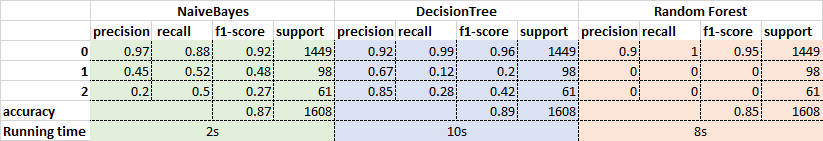
##### Among the three models, DecisionTree appears the most promising, with high precision in class 0 and 2 and average precision in class 1. However, recall in classes 1 and 2 remains very low. All three models run quite fast. Despite DecisionTree's performance, it is still not considered suitable.
#### After OverSampling
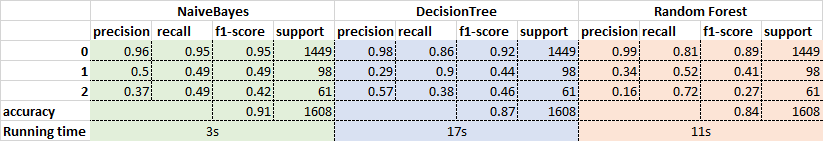
##### Even after Oversampling, NaiveBayes emerges as the best model among the three, but its performance has not improved compared to before Oversampling, and the model remains unsuitable.
##### => Need to collect more data